# Try PyOD

* Basic experiments to observe the performance of PyOD anomalies detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.font_manager

## 2D Simulated Data

* Small data amount, just 200 records
* 2 features - 2D
* Besides calculate the anomaly score for each record among the 200 records, each algorithm also needs to calculate all the points on meshgrid (200*200 points) - from here we can also see whether a PyOD implementation works well for large amount of records

In [75]:
from pyod.utils.data import generate_data, get_outliers_inliers

outlier_fraction = 0.01
total_records = 200

# 5% outliers, better to set random_state, otherwise it's difficult to differentiate inliners and outliers in plot
X_train, y_train = generate_data(n_train=total_records,train_only=True, n_features=2, contamination=outlier_fraction,
                                 random_state = 10)
x_outliers, x_inliers = get_outliers_inliers(X_train, y_train)

n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

print(n_inliers, n_outliers)

(198, 2)


In [76]:
print(X_train[:10])
print(y_train[:10])
print(np.unique(y_train, return_counts=True))

[[ 8.12134237  8.91658164]
 [ 9.08988677  9.35806311]
 [ 8.72853316  8.73078769]
 [ 9.13545602  8.74236303]
 [ 8.83968938  9.30961464]
 [ 8.95916181  9.0528698 ]
 [ 9.09318097  9.51839971]
 [ 8.9278589   8.69203977]
 [ 9.12710325  9.42224982]
 [ 9.13189251  8.87163196]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(array([ 0.,  1.]), array([198,   2]))


In [77]:
# 1 features
f1 = X_train[:,[0]]
f2 = X_train[:,[1]]

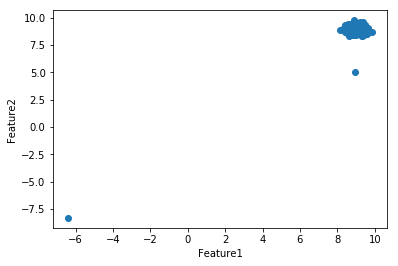

In [78]:
# The cluster at top right corner is inliners, others (10 points) are outliers
plt.scatter(f1,f2)
plt.xlabel('Feature1')
plt.ylabel('Feature2') 
plt.show()

In [79]:
# create a meshgrid 
## 200 points, the ploted meshgrid has both x-axis, y-axis in [-10, 10] range
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
xx

array([[-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       ..., 
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ],
       [-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
          9.89949749,  10.        ]])

In [80]:
# check some data structures used below
print(xx.shape)
print(xx.ravel().shape)  # ravel() method convert 200*200 matrix into a 40000 list
xx.ravel()

(200, 200)
(40000,)


array([-10.        ,  -9.89949749,  -9.79899497, ...,   9.79899497,
         9.89949749,  10.        ])

In [81]:
# check some data structures used below
print(np.c_[xx.ravel(), yy.ravel()].shape)
np.c_[xx.ravel(), yy.ravel()]

(40000, 2)


array([[-10.        , -10.        ],
       [ -9.89949749, -10.        ],
       [ -9.79899497, -10.        ],
       ..., 
       [  9.79899497,  10.        ],
       [  9.89949749,  10.        ],
       [ 10.        ,  10.        ]])

In [82]:
# import models 
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP

random_state = 10

classifiers = {# Linear Models
               'One-class SVM (OCSVM)': OCSVM(contamination=outlier_fraction),
               'Minimum Covariance Determinant (MCD)': MCD(contamination=outlier_fraction, random_state=random_state),
               'Principal Component Analysis (PCA)': PCA(contamination=outlier_fraction, random_state=random_state),
               
               # Proximity-Based Models
               'Local Outlier Factor (LOF)': LOF(n_neighbors=40, contamination=outlier_fraction),
               'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outlier_fraction,
                                                  check_estimator=False, random_state=random_state),
               'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outlier_fraction),
               'K Nearest Neighbors (KNN)': KNN(contamination=outlier_fraction),
               'Average KNN': KNN(method='mean', contamination=outlier_fraction),
    
               # Probabilistic Models
               'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outlier_fraction),
    
               # Outlier Ensembles
               'Feature Bagging': FeatureBagging(LOF(n_neighbors=40), # more neighbor, higher plot precision
                       contamination=outlier_fraction,
                       check_estimator=False,
                       random_state=random_state),
               'Isolation Forest': IForest(contamination=outlier_fraction,
                                random_state=random_state)
              }


(1, 'fitting', 'Histogram-base Outlier Detection (HBOS)')
('Number of Errors : ', 'Histogram-base Outlier Detection (HBOS)', 2, 'Percentage of Errors: ', '1.0%')

(2, 'fitting', 'Local Outlier Factor (LOF)')
('Number of Errors : ', 'Local Outlier Factor (LOF)', 0, 'Percentage of Errors: ', '0.0%')

(3, 'fitting', 'One-class SVM (OCSVM)')
('Number of Errors : ', 'One-class SVM (OCSVM)', 0, 'Percentage of Errors: ', '0.0%')

(4, 'fitting', 'Principal Component Analysis (PCA)')
('Number of Errors : ', 'Principal Component Analysis (PCA)', 0, 'Percentage of Errors: ', '0.0%')

(5, 'fitting', 'Isolation Forest')
('Number of Errors : ', 'Isolation Forest', 0, 'Percentage of Errors: ', '0.0%')

(6, 'fitting', 'Angle-based Outlier Detector (ABOD)')
('Number of Errors : ', 'Angle-based Outlier Detector (ABOD)', 1, 'Percentage of Errors: ', '0.5%')

(7, 'fitting', 'K Nearest Neighbors (KNN)')
('Number of Errors : ', 'K Nearest Neighbors (KNN)', 0, 'Percentage of Errors: ', '0.0%')

(8, 'fitting

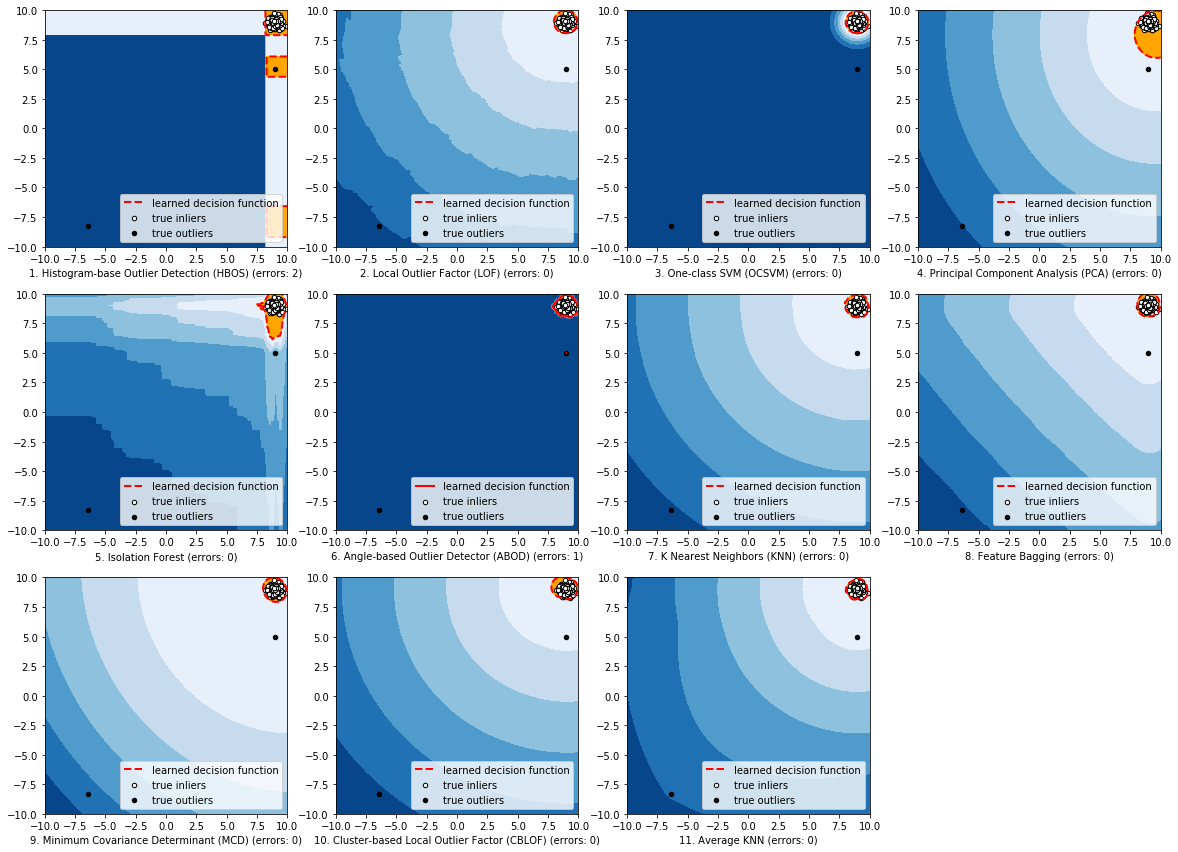

In [83]:
# Fit the model
plt.figure(figsize=(20, 20))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    print
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(X_train)
    scores_pred = clf.decision_function(X_train) * -1  # predicted anomaly score
    y_pred = clf.predict(X_train)  # predict whether inliner or outlier
    # threshold is the specified percentile (100 * outlier_fraction) at a list of scores_pred
    threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_fraction)
    n_errors = (y_pred != y_train).sum()
    print('Number of Errors : ', clf_name, n_errors, 'Percentage of Errors: ', str(n_errors*100.0/total_records)+'%')

    # plot the results
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1  # predicted anomaly score for each (x,y) point on meshgrid
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(4,4, i + 1)
    
    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    # inliner white dots; outlier black dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white', s=20, edgecolor='k')
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black', s=20, edgecolor='k')
    subplot.axis('tight')
    subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
    subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show()

### Observations

* When doing this experiment, I have tried 0.01 outlier fraction (2 outliers out of 200 records), and 0.05 (10 outliers out of 200 records). Because in real world practice, there are too many situations when you have less than 1% outliers. Based on this small set of data experiments, 0.01 and 0.05 got almost the same accuracy. However this also depends on how did the outliers got generated.
* Even with such small set of data, 200 records, 40000 points on meshgrid need to calculate anomaly score, there are still a few algorithms in PyOD running very slow and veen could not output anything in hours:
  * LSCP
  * SOS
  * LOCI
* Other methods are all very fast, ABOD is a bit slower
* Now let's observe the plot above:
  * The blue color map indicates the anomaly score, lower the score, lighter the blue color will be. So as we can see, ABOD and OCSVM tend we seperate inliners and outliers more clear,because the 2 outleirs tend to have higher anomaly score in these 2 algorithms, comparing with other algorithms.
  * For LOF and Feature Bagging, higher number of neighbours, higher precision the plot will have
  * Also need to pay attention to the orange area in the plots. It's the area that predicted anomaly score smaller than the threshold. That's to say, when this area is larger than the cluster of inliners, it also tend include outliers.

In [ ]:
# TO-DO
## try 3D
## multi-dimensional, plot with tSNE and try